#  Portfolio Optimization - Markowitz Efficient Frontier 

In this problem, we will find the unconstrained portfolio allocation where we introduce the weighting parameter $\lambda \;(0 \leq \lambda \leq$ 1) and minimize $\lambda * \text{risk} - (1-\lambda)* \text{expected return}$. By varying the values of $\lambda$, we trace out the efficient frontier.  

Suppose that we know the mean returns $\mu \in \mathbf{R}^n$ of each asset and the covariance $\Sigma \in \mathbf{R}^{n \times n}$ between the assets. Our objective is to find a portfolio allocation that minimizes the *risk* (which we measure as the variance $w^T \Sigma w$) and maximizes the *expected return* ($w^T \mu$) of the portfolio of the simulataneously. We require $w \in \mathbf{R}^n$ and $\sum_i w_i = 1$.

This problem can be written as

$
\begin{array}{ll}
    \mbox{minimize}   & \lambda*w^T \Sigma w - (1-\lambda)*w^T \mu \\
    \mbox{subject to} & \sum_i w_i = 1
\end{array}
$

where $w \in \mathbf{R}^n$ is the vector containing weights allocated to each asset.

In [1]:
using Convex, SCS    #We are using SCS solver. Install using Pkg.add("SCS")

# generate problem data
μ = [11.5; 9.5; 6]/100          #expected returns
Σ  = [166  34  58;              #covariance matrix
       34  64   4;
       58   4 100]/100^2

n = length(μ)                   #number of assets 

3

If you want to try the optimization with more assets, uncomment and run the next cell. It creates a vector or average returns and a variance-covariance matrix that have scales similar to the numbers above.

In [2]:
#=
using Random
Random.seed!(123)

n = 15                                      #number of assets, CHANGE IT?

μ = (6 .+ (11.5-6)*rand(n))/100             #mean
A = randn(n,n)
Σ = (A * A' + diagm(0=>rand(n)))/500;       #covariance matrix
=#

First we solve without any bounds on $w$

In [3]:
N = 101
λ_vals = range(0.01,stop=0.99,length=N)

w    = Variable(n)
ret  = dot(w,μ)
risk = quadform(w,Σ)

MeanVarA = zeros(N,2)                    
for i = 1:N
    λ = λ_vals[i]
    p = minimize( λ*risk - (1-λ)*ret,
                  sum(w) == 1 )    
    solve!(p, SCSSolver(verbose = false))
    MeanVarA[i,:]= [evaluate(ret),evaluate(risk)[1]]    #risk is a 1x1 matrix
end

Now we solve with the bounds $0\le w_i \le 1$

In [4]:
w_lower = 0                     #bounds on w
w_upper = 1

MeanVarB = zeros(N,2)   #repeat, but with 0<w[i]<1
for i = 1:N
    λ = λ_vals[i]
    p = minimize( λ*risk - (1-λ)*ret,
                  sum(w) == 1,
                  w_lower <= w,     #w[i] is bounded
                  w <= w_upper )
    solve!(p, SCSSolver(verbose = false))
    MeanVarB[i,:]= [evaluate(ret),evaluate(risk)[1]]    
end

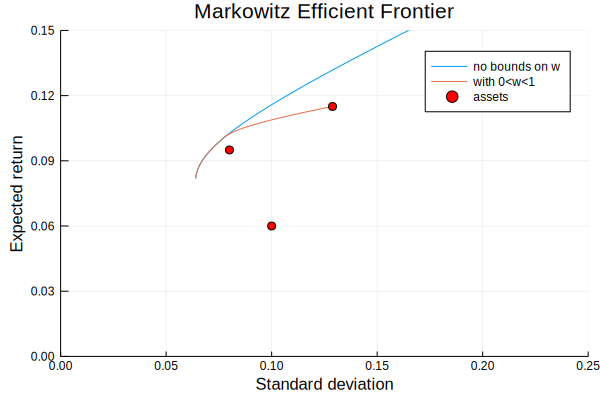

In [5]:
using Plots
plot( sqrt.([MeanVarA[:,2] MeanVarB[:,2]]),
      [MeanVarA[:,1] MeanVarB[:,1]],
      xlim = (0,0.25),
      ylim = (0,0.15),
      title = "Markowitz Efficient Frontier",
      xlabel = "Standard deviation",
      ylabel = "Expected return",
      label = ["no bounds on w","with 0<w<1",])
scatter!(sqrt.(diag(Σ)),μ,color=:red,label = "assets")

We now instead impose a restriction on  $\sum_i |w_i| - 1$, allowing for varying degrees of "leverage".

In [6]:
Lmax = 0.5

MeanVarC = zeros(N,2)   #repeat, but with restriction on Sum(|w[i]|)
for i = 1:N
    λ = λ_vals[i]
    p = minimize( λ*risk - (1-λ)*ret,
                  sum(w) == 1,
                  (norm(w, 1)-1) <= Lmax)
    solve!(p, SCSSolver(verbose = false))
    MeanVarC[i,:]= [evaluate(ret),evaluate(risk)[1]]    
end

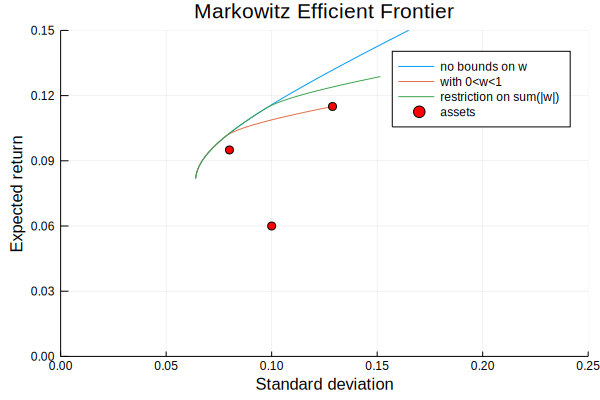

In [7]:
plot( sqrt.([MeanVarA[:,2] MeanVarB[:,2] MeanVarC[:,2]]),
      [MeanVarA[:,1] MeanVarB[:,1] MeanVarC[:,1]],
      xlim = (0,0.25),
      ylim = (0,0.15),
      title = "Markowitz Efficient Frontier",
      xlabel = "Standard deviation",
      ylabel = "Expected return",
      label = ["no bounds on w","with 0<w<1","restriction on sum(|w|)"])
scatter!(sqrt.(diag(Σ)),μ,color=:red,label = "assets")